In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD

In [3]:
# load the dataset.
df = pd.read_csv('/opt/ShadData/NLP/Womens Clothing E-Commerce Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
# list of column names.
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [5]:
# there are 23486 rows and 11 columns.
df.shape

(23486, 11)

In [6]:
# take out the 'Unnamed: 0' and 'Clothing ID' column.
# don't think they will be useful for my analysis.
df = df.drop(['Unnamed: 0', 'Clothing ID'], axis=1)


In [7]:
# clean the white space from the column names.
df = df.rename(columns=lambda x: x.replace(' ', ''))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
Age                      23486 non-null int64
Title                    19676 non-null object
ReviewText               22641 non-null object
Rating                   23486 non-null int64
RecommendedIND           23486 non-null int64
PositiveFeedbackCount    23486 non-null int64
DivisionName             23472 non-null object
DepartmentName           23472 non-null object
ClassName                23472 non-null object
dtypes: int64(4), object(5)
memory usage: 1.6+ MB


In [9]:
# Missing value percentage
df.isnull().sum() / df.shape[0] * 100 

Age                       0.000000
Title                    16.222430
ReviewText                3.597888
Rating                    0.000000
RecommendedIND            0.000000
PositiveFeedbackCount     0.000000
DivisionName              0.059610
DepartmentName            0.059610
ClassName                 0.059610
dtype: float64

In [10]:
# dorpping NAs for 4 columns.
subset = ['ReviewText', 'DivisionName', 'DepartmentName', 'ClassName']
df = df.dropna(subset=subset)

print('Now length of df is: ', len(df))

Now length of df is:  22628


In [11]:
# first fill NAs in the Title column with space, so I can concatenate the Title and ReviewText column together.
df.Title.fillna('', inplace=True)

# create a new column named CombinedText with Title and ReviewText.
df['CombinedText'] = df.Title + ' ' + df.ReviewText

# drop the Title column.
df.drop('Title', axis=1, inplace=True)

In [12]:
df.describe()

,Age,Rating,RecommendedIND,PositiveFeedbackCount
count,22628.000000,22628.000000,22628.000000,22628.000000
mean,43.282880,4.183092,0.818764,2.631784
std,12.328176,1.115911,0.385222,5.787520
min,18.000000,1.000000,0.000000,0.000000
25%,34.000000,4.000000,1.000000,0.000000
50%,41.000000,5.000000,1.000000,1.000000
75%,52.000000,5.000000,1.000000,3.000000
max,99.000000,5.000000,1.000000,122.000000


In [13]:
df.to_pickle('cleaned_df.pkl')

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud

## Reading the cleaned data from EDA

In [15]:
df = pd.read_pickle('cleaned_df.pkl')
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


In [16]:
words_to_remove = ['love', 'dress', 'dresses', 'zip', 'zipper', 'fit', 'zippers', 'young', 'younger', 'pants', 'years']
text = 'I love things about dresses but not dress.'

import re
pattern = [f'(\\b{word}\\b)' for word in words_to_remove]
pattern = '|'.join(pattern)
re.sub(pattern, '', text)

'I  things about  but not .'

In [17]:
df['ReviewTextLower'] = df.ReviewText

In [18]:
df['ReviewTextLower'] = df.ReviewTextLower.str.lower()

In [19]:
df['ReviewTextLower'].replace(to_replace=pattern, value='', regex=True, inplace=True)

In [20]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6, max_features=4000)

cv_data = count_vectorizer.fit_transform(df.ReviewTextLower)


In [21]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6, max_features=4000)

tfidf_data = tfidf_vectorizer.fit_transform(df.ReviewTextLower)

In [22]:
len(tfidf_vectorizer.get_feature_names())

4000

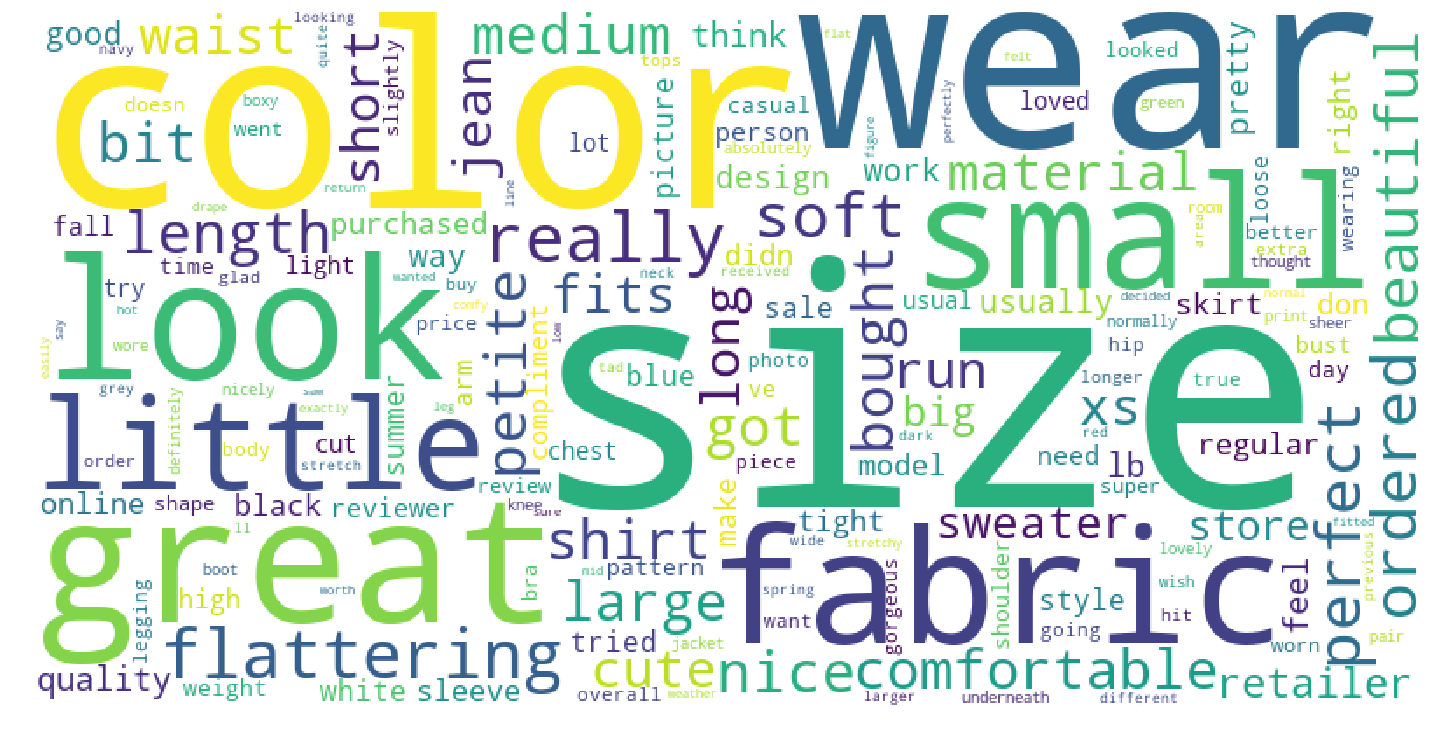

In [23]:
for_wordcloud = count_vectorizer.get_feature_names()
for_wordcloud_str = ' '.join(for_wordcloud)

wordcloud = WordCloud(width=800, height=400, background_color ='white',
                      min_font_size = 7).generate(for_wordcloud_str)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
 
plt.show()

In [148]:
from collections import Counter

word_count = Counter(for_wordcloud_str.lower().split())
word_count.most_common()

[('size', 126),
 ('wear', 98),
 ('just', 97),
 ('great', 95),
 ('like', 83),
 ('fabric', 77),
 ('color', 75),
 ('small', 74),
 ('little', 56),
 ('flattering', 55),
 ('really', 55),
 ('look', 54),
 ('perfect', 47),
 ('soft', 46),
 ('ordered', 46),
 ('beautiful', 41),
 ('nice', 39),
 ('length', 39),
 ('bought', 39),
 ('petite', 38),
 ('comfortable', 37),
 ('large', 37),
 ('got', 37),
 ('bit', 36),
 ('medium', 35),
 ('shirt', 34),
 ('waist', 34),
 ('xs', 34),
 ('cute', 34),
 ('colors', 33),
 ('fits', 33),
 ('looks', 33),
 ('long', 32),
 ('material', 30),
 ('jeans', 28),
 ('short', 27),
 ('sweater', 26),
 ('retailer', 26),
 ('big', 25),
 ('quality', 25),
 ('store', 25),
 ('think', 25),
 ('lbs', 24),
 ('usually', 23),
 ('pretty', 23),
 ('design', 22),
 ('runs', 22),
 ('good', 22),
 ('way', 22),
 ('purchased', 22),
 ('online', 21),
 ('work', 21),
 ('regular', 21),
 ('don', 20),
 ('black', 19),
 ('didn', 18),
 ('model', 17),
 ('right', 17),
 ('white', 16),
 ('tried', 16),
 ('skirt', 15),
 ('s

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

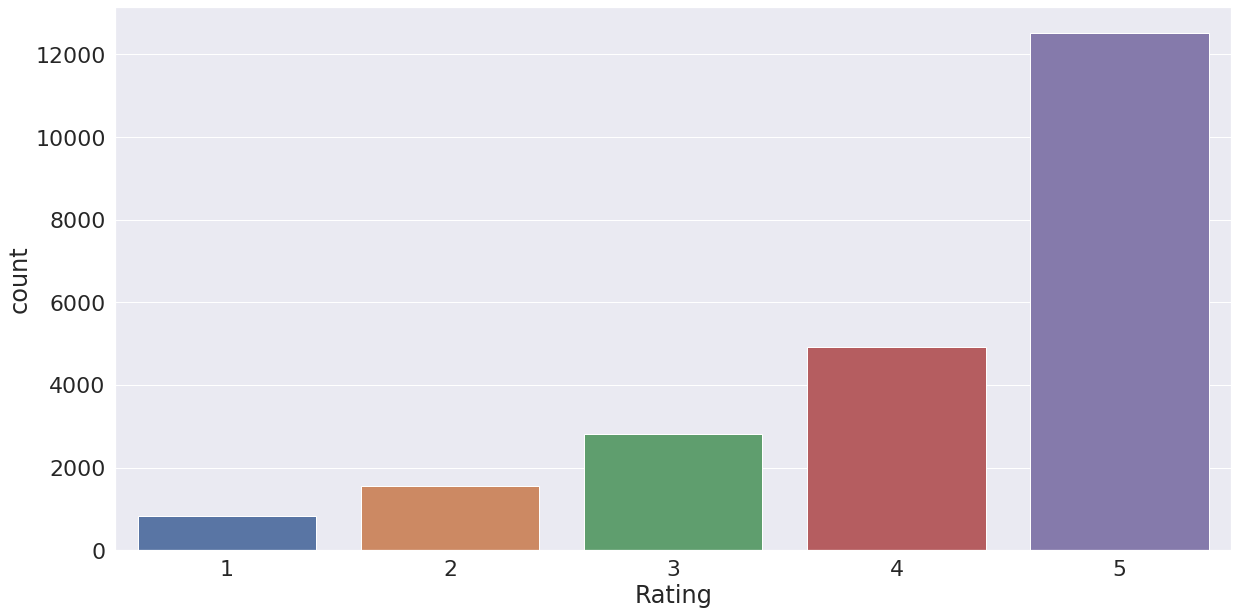

In [150]:
plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
sns.countplot(df.Rating)

In [151]:
df.groupby('Rating')['ReviewTextLower'].nunique()

Rating
1      821
2     1548
3     2823
4     4908
5    12521
Name: ReviewTextLower, dtype: int64

In [152]:
df.Rating.value_counts()

5    12527
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: int64

In [153]:
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText,ReviewTextLower
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...,absolutely wonderful - silky and sexy and comf...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...,this ! it's sooo pretty. i happened to find...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,i had such high hopes for this and really wan...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...","i , , this jumpsuit. it's fun, flirty, and fa..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,this shirt is very flattering to all due to th...


## Group different ranks together as my target rank

In [154]:
df['ModifiedRating'] = df.Rating.replace([2, 3, 4], 1)

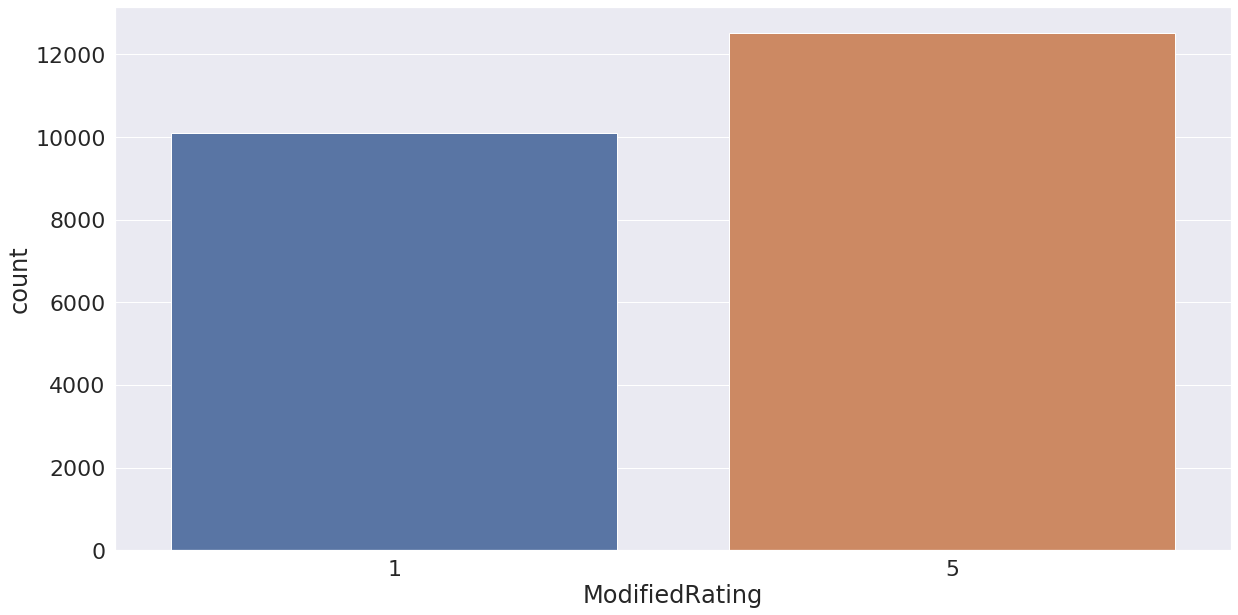

In [155]:
sns.set(font_scale = 2)
plt.figure(figsize=(20,10))
sns.countplot(df.ModifiedRating)

In [157]:
len(df[df.ModifiedRating == 1])

10101

In [158]:
len(df[df.ModifiedRating == 5])

12527

In [159]:
## Build different classification models

#### Using ReviewTextLower column

# using ReviewTextLower column as my predictors
# using ModifiedRating column as my target variable
X = df['ReviewTextLower']
y = df['ModifiedRating']

# vectorization
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

# transform my predictors
cv_data = count_vectorizer.fit_transform(X)
tfidf_data = tfidf_vectorizer.fit_transform(X)

In [162]:
len(count_vectorizer.vocabulary_)

254500

In [170]:
cv_data.shape

(22628, 254500)

In [171]:
# split my data to 70/30 
X_train, X_test, y_train, y_test = train_test_split(cv_data, y, test_size=0.3, random_state=42)

# train with multinomail Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [172]:
# make prediction
y_pred = nb.predict(X_test)

In [173]:
# print out confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[2129  896]
 [ 462 3302]]


              precision    recall  f1-score   support

           1       0.82      0.70      0.76      3025
           5       0.79      0.88      0.83      3764

    accuracy                           0.80      6789
   macro avg       0.80      0.79      0.79      6789
weighted avg       0.80      0.80      0.80      6789



In [174]:
# trying to make a prediction using this review
# this is an example for positive review
positive_example = df['ReviewTextLower'][1]
positive_example

' this !  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i  the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [177]:
# vectorize the positive_example
positive_example_vec = count_vectorizer.transform([positive_example])
# make prediction
nb.predict(positive_example_vec)[0]

5

In [178]:
# trying to make a prediction using an negative review
negative_example = df['ReviewTextLower'][5]
negative_example

'i  tracy reese , but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this  was very pretty out of the package but its a lot of . the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i  the color and the idea of the style but it just did not work on me. i returned this .'

In [179]:
negative_example_vec = count_vectorizer.transform([negative_example])
nb.predict(negative_example_vec)[0]

1

In [183]:
### TF IDF Performs Better
negative_manual_example = "Skirt Doesn't Fit to my size as expected from pictures, its not perfect"
negative_manual_example_vec = tfidf_vectorizer.transform([negative_manual_example])
nb.predict(negative_manual_example_vec)[0]

1

In [182]:
negative_manual_example = "Skirt Doesn't Fit to my size as expected from pictures, its not perfect"
negative_manual_example_vec = count_vectorizer.transform([negative_manual_example])
nb.predict(negative_manual_example_vec)[0]

5

In [185]:
negative_example = df['ReviewTextLower'][10]
negative_example

' runs small esp where the  area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will cause it to rip the fabric. pretty disappointed as it was going to be my christmas  this year! needless to say it will be going back.'

In [187]:
negative_example_vec = count_vectorizer.transform([negative_example])
nb.predict(negative_example_vec)[0]

1

#### Using Combinetext column

In [188]:
df['CombinedTextLower'] = df.CombinedText

In [189]:
df['CombinedTextLower'] = df.CombinedTextLower.str.lower()

In [190]:
df['CombinedTextLower'].replace(to_replace=pattern, value='', regex=True, inplace=True)

In [191]:
X = df.CombinedTextLower
y = df.ModifiedRating

In [192]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(X)
tfidf_data = tfidf_vectorizer.fit_transform(X)

In [193]:
len(count_vectorizer.vocabulary_)

267875

In [194]:
X_train, X_test, y_train, y_test = train_test_split(cv_data, y, test_size=0.3, random_state=42)

In [195]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [196]:
y_pred = nb.predict(X_test)

In [197]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[2177  848]
 [ 424 3340]]


              precision    recall  f1-score   support

           1       0.84      0.72      0.77      3025
           5       0.80      0.89      0.84      3764

    accuracy                           0.81      6789
   macro avg       0.82      0.80      0.81      6789
weighted avg       0.82      0.81      0.81      6789



In [199]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(X_train, y_train)

/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [200]:
y_pred = logit.predict(X_test)

In [201]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[2250  775]
 [ 554 3210]]


              precision    recall  f1-score   support

           1       0.80      0.74      0.77      3025
           5       0.81      0.85      0.83      3764

    accuracy                           0.80      6789
   macro avg       0.80      0.80      0.80      6789
weighted avg       0.80      0.80      0.80      6789



In [202]:
positive_example = df['CombinedTextLower'][1]
positive_example

'  this !  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i  the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [204]:
positive_example_vec = tfidf_vectorizer.transform([positive_example])
logit.predict(positive_example_vec)[0]

5

In [205]:
negative_example=df['ReviewTextLower'][5]
negative_example

'i  tracy reese , but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this  was very pretty out of the package but its a lot of . the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i  the color and the idea of the style but it just did not work on me. i returned this .'

In [207]:
negative_example_vec = tfidf_vectorizer.transform([negative_example])
logit.predict(negative_example_vec)[0]

1

In [208]:
negative_example=df['ReviewTextLower'][23484]
negative_example

"i bought this  for a wedding i have this summer, and it's so cute. unfortunately the  isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and shoulders. if i wanted to spend the money, i could get it tailored, but i just felt like it might not be worth it. side note - this  was delivered to me with a nordstrom tag on it and i found it much cheaper there after looking!"

In [209]:
negative_example_vec = count_vectorizer.transform([negative_example])
logit.predict(negative_example_vec)[0]

1

# predicting recommend or not

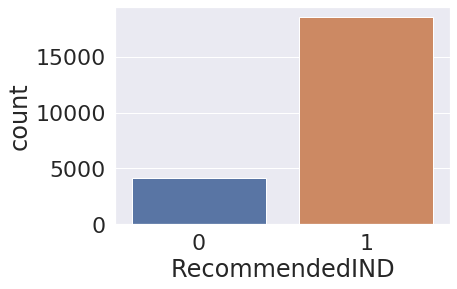

In [210]:
sns.countplot(df.RecommendedIND)

In [211]:
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText,ReviewTextLower,ModifiedRating,CombinedTextLower
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...,absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful - silky and sexy and com...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...,this ! it's sooo pretty. i happened to find...,5,this ! it's sooo pretty. i happened to fin...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,i had such high hopes for this and really wan...,1,some major design flaws i had such high hopes ...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...","i , , this jumpsuit. it's fun, flirty, and fa...",5,"my favorite buy! i , , this jumpsuit. it's fu..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,this shirt is very flattering to all due to th...,5,flattering shirt this shirt is very flattering...


In [212]:
#rating_class = df[(df['Rating'] == 1) | (df['Rating'] == 5)]
X = df.CombinedTextLower
y = df.RecommendedIND

In [213]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(X)
tfidf_data = tfidf_vectorizer.fit_transform(X)

In [214]:
len(count_vectorizer.vocabulary_)

267875

In [215]:
X_train, X_test, y_train, y_test = train_test_split(cv_data, y, test_size=0.3, random_state=42, stratify=y)

In [216]:
# using SMOTE to oversample
X_train_smoted, y_train_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [217]:
print(Counter(y_train_smoted))

Counter({1: 12968, 0: 12968})


In [218]:
nb = MultinomialNB()
nb.fit(X_train_smoted, y_train_smoted)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [219]:
y_pred = nb.predict(X_test)

In [220]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[ 753  477]
 [ 263 5296]]


              precision    recall  f1-score   support

           0       0.74      0.61      0.67      1230
           1       0.92      0.95      0.93      5559

    accuracy                           0.89      6789
   macro avg       0.83      0.78      0.80      6789
weighted avg       0.89      0.89      0.89      6789



In [221]:
logit = LogisticRegression()
logit.fit(X_train_smoted, y_train_smoted)

/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [222]:
y_pred = logit.predict(X_test)

In [223]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[ 831  399]
 [ 490 5069]]


              precision    recall  f1-score   support

           0       0.63      0.68      0.65      1230
           1       0.93      0.91      0.92      5559

    accuracy                           0.87      6789
   macro avg       0.78      0.79      0.79      6789
weighted avg       0.87      0.87      0.87      6789



In [224]:
positive_example = df['CombinedTextLower'][1]
positive_example

'  this !  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i  the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [226]:
positive_example_vec = count_vectorizer.transform([positive_example])
logit.predict(positive_example_vec)[0]

1

In [229]:
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText,ReviewTextLower,ModifiedRating,CombinedTextLower
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...,absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful - silky and sexy and com...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...,this ! it's sooo pretty. i happened to find...,5,this ! it's sooo pretty. i happened to fin...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,i had such high hopes for this and really wan...,1,some major design flaws i had such high hopes ...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...","i , , this jumpsuit. it's fun, flirty, and fa...",5,"my favorite buy! i , , this jumpsuit. it's fu..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,this shirt is very flattering to all due to th...,5,flattering shirt this shirt is very flattering...


In [230]:
negative_example = df['CombinedTextLower'][2]
negative_example

'some major design flaws i had such high hopes for this  and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not  it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and  nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the  - it c'

In [232]:
negative_example_vec = tfidf_vectorizer.transform([negative_example])
logit.predict(negative_example_vec)[0]

0

### Try Topic Modelings

In [14]:
# def functions for topic modelings
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def display_topics2(model, feature_names, no_top_words=10, topic_names = None):
    for index, topic in enumerate(model.components_):
        if not topic_names or not topic_names[index]:
            print(f"\nTopic {index}")
        else:
            print(f"\nTopic {topic_names[index]}:")
        msg = ", ".join([f'{feature_names[i]} ({topic[i]:6.4f})' 
                             for i in topic.argsort()[:-no_top_words-1:-1]])
        print(msg)

In [56]:
# try using 50 dimensions
n_comp = 50
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_tfidf = NMF(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
lsa_cv_data = lsa_cv.fit_transform(cv_data)
nmf_tfidf_data = nmf_tfidf.fit_transform(tfidf_data)
nmf_cv_data = nmf_cv.fit_transform(cv_data)

In [ ]:
### Count Vectorizer performs good for recommendation engine